In [1]:
# initial_path = 'peptide-QML/'
initial_path = '../'

In [2]:
day = "0809"
name_notebook = day + "-sh_em_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

In [8]:
input_data.shape, target_data.shape, input_validation.shape, target_validation.shape

(torch.Size([9000, 4]),
 torch.Size([9000, 1]),
 torch.Size([1000, 4]),
 torch.Size([1000, 1]))

# Quantum node

In [83]:
n_aminoacids = len(string_list[0])

In [94]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.Measurement('Z', 1),
    embedding_n_layers = 4,
    different_inputs_per_layer = True,
    block_n_layers = 50,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

In [95]:
quantum_layer.weights_shape, quantum_layer.input_shape

({'embedding_weights': (24,), 'block_weights': (120,)}, (12,))

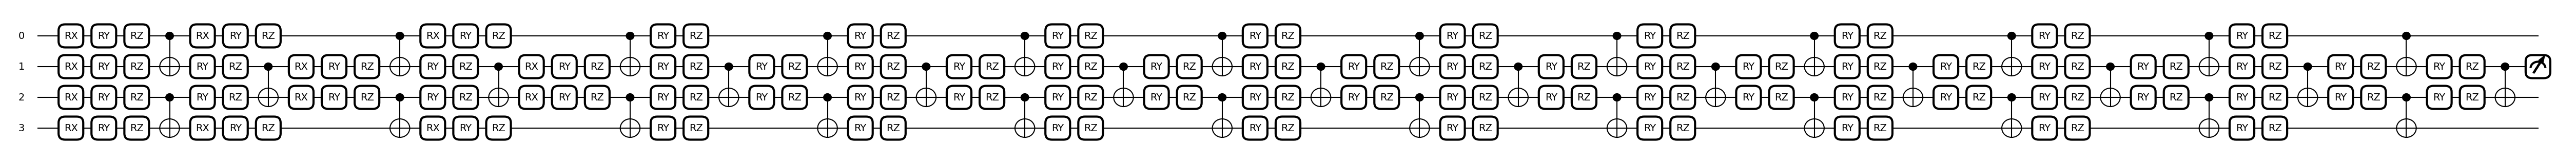

In [96]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [97]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [98]:
import torch.nn as nn
import torch
class ClippedReLU(nn.Module):
    def __init__(self, clip_val=1):
        super(ClippedReLU, self).__init__()
        self.clip_val = clip_val

    def forward(self, x):
        return torch.clamp(x, 0, self.clip_val)
    
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

In [99]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
layers += [quantum_layer()]


In [100]:
# layers = []
# for i in range(1, len(layers_dim)):
#     layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
# layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0]), ClippedReLU()]
# layers += [quantum_layer()]
# # layers += [nn.Linear(1, 1)]
# # layers += [nn.Linear(2, 4), nn.ReLU()]
# # layers += [nn.Linear(4, 1)]

In [101]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [102]:
x = model.model[0](input_data[0:2])
print(x, x.shape)

x = model.model[1](x)
print(x, x.shape)

x = model.model[2](x)
print(x)

tensor([[-0.2414],
        [-0.0629],
        [-0.1206],
        [-0.0324],
        [ 0.2953],
        [ 0.0182],
        [-0.5751],
        [ 0.0095],
        [ 0.3333],
        [ 0.2462]], grad_fn=<ReshapeAliasBackward0>)


In [103]:
for i in range(2):
    x = model.model[0](input_data[i])
    print(x, x.shape)

    x = model.model[1](x)
    print(x, x.shape)

    x = model.model[2](x)
    print(i, x)

0 tensor([-0.2414], grad_fn=<CatBackward0>)
1 tensor([-0.0629], grad_fn=<CatBackward0>)
2 tensor([-0.1206], grad_fn=<CatBackward0>)
3 tensor([-0.0324], grad_fn=<CatBackward0>)
4 tensor([0.2953], grad_fn=<CatBackward0>)
5 tensor([0.0182], grad_fn=<CatBackward0>)
6 tensor([-0.5751], grad_fn=<CatBackward0>)
7 tensor([0.0095], grad_fn=<CatBackward0>)
8 tensor([0.3333], grad_fn=<CatBackward0>)
9 tensor([0.2462], grad_fn=<CatBackward0>)


In [81]:
print(model(input_data[0:2]))
print(model(input_data[1]))

Bff tensor([[ 0.9957,  1.2563,  1.1721, -0.5967,  1.8172, -2.2409, -0.3574,  1.3067,
          0.5670, -1.2074, -0.1032, -0.6858],
        [ 1.3305, -0.1658, -0.8200,  1.1721, -1.1396,  1.0572,  0.3367, -0.3574,
         -1.3857,  0.3306,  0.6796, -0.1032]], grad_fn=<ReshapeAliasBackward0>)
ff Parameter containing:
tensor([6.2321, 0.5011, 4.2023, 2.1736, 1.6782, 4.0883, 3.3459, 3.7133, 4.8692,
        4.0949, 0.8743, 6.2587, 4.1785, 4.3326, 0.1681, 3.1666, 3.9051, 1.9979,
        2.5040, 6.0285, 2.3336, 4.5492, 3.5195, 1.2928], requires_grad=True)
ff [tensor([6.2321, 0.5011, 4.2023, 2.1736, 1.6782, 4.0883, 3.3459, 3.7133, 4.8692,
        4.0949, 0.8743, 6.2587], grad_fn=<TransposeBackward0>), tensor([4.1785, 4.3326, 0.1681, 3.1666, 3.9051, 1.9979, 2.5040, 6.0285, 2.3336,
        4.5492, 3.5195, 1.2928], grad_fn=<TransposeBackward0>)]
fs [tensor([[ 0.9957,  1.2563,  1.1721, -0.5967],
        [ 1.3305, -0.1658, -0.8200,  1.1721]], grad_fn=<TransposeBackward0>), tensor([[ 1.8172, -2.2409,

In [21]:
model.keep_track_params=True,

In [22]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.05},
    num_epochs = 50,                
    batch_size = 32,
)

SystemExit: 

d:\Raul\Programs\envs\PennyLane\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0807/txts/0807-sh_e_1qm_model_str_6.txt


Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_losses_batches_6.png


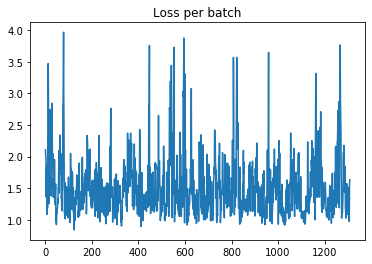

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_losses_epoch_6.png


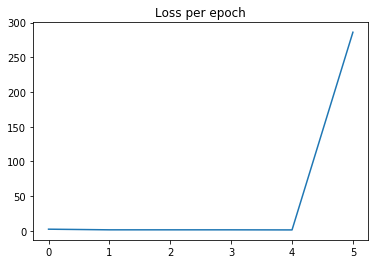

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_losses_epoch_validation_6.png


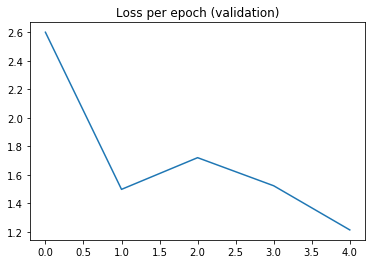

In [ ]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True)

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_parameter_0.weight_None_6.png


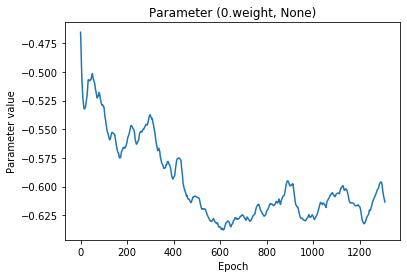

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_parameter_2.qlayer.embedding_weights_None_6.png


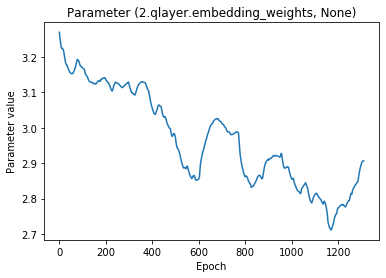

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_parameter_2.qlayer.block_weights_None_6.png


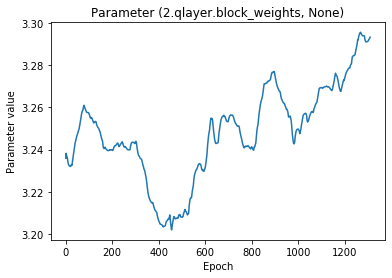

In [ ]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

In [ ]:
# model.plot_parameter(layer='7.weights', index=50)

KeyError: '7.weights'

In [ ]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=True)

Model saved as peptide-QML/checkpoints/0804/models/0804-sq_1qm_3.pth and intermediate parameters saved in peptide-QML/checkpoints/0804/models/0804-sq_1qm_3


In [ ]:
# print validation and save it
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: 0.1732, 	 output: 0.1576, 	 loss: 0.0899
i: 1, 		 target: -0.0421, 	 output: 0.1618, 	 loss: 4.8403
i: 2, 		 target: 0.1847, 	 output: 0.1572, 	 loss: 0.1487
i: 3, 		 target: 0.1907, 	 output: 0.1538, 	 loss: 0.1934
i: 4, 		 target: 0.2102, 	 output: -0.3036, 	 loss: 2.4444
i: 5, 		 target: -0.0833, 	 output: 0.2136, 	 loss: 3.5647
i: 6, 		 target: -0.0828, 	 output: 0.1516, 	 loss: 2.8315
i: 7, 		 target: 0.0895, 	 output: 0.1640, 	 loss: 0.8327
i: 8, 		 target: -0.0262, 	 output: -0.3572, 	 loss: 12.6378
i: 9, 		 target: 0.3678, 	 output: 0.1620, 	 loss: 0.5595
i: 10, 		 target: -0.0480, 	 output: 0.0098, 	 loss: 1.2041
i: 11, 		 target: -0.0758, 	 output: 0.1570, 	 loss: 3.0726
i: 12, 		 target: 0.1918, 	 output: 0.1572, 	 loss: 0.1805
i: 13, 		 target: 0.1802, 	 output: 0.1454, 	 loss: 0.1931
i: 14, 		 target: 0.0937, 	 output: 0.1630, 	 loss: 0.7405
i: 15, 		 target: -0.0651, 	 output: 0.0010, 	 loss: 1.0154
i: 16, 		 target: 0.1439, 	 output: -0.3736, 	 loss: 3.5

In [ ]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
